In [1]:
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import bnpy
import warnings
from scipy import stats
import random

from scipy.stats import kruskal, f_oneway
import collections
import scikit_posthocs as sp

warnings.filterwarnings('ignore')

In [2]:
genes = """
IGHV4-4
CD1E
IGKV1-16
TGFB2
IGHV3-73
UCN3
CRH
FGF19
IGKV1D-13
ALDH1A2
IGLV3-10
FZD5
GCNT2
SOX10
TAC1
NPAS4
IGHV1-3
TRDC
INHBA
XCL1
FOSL1
IGHV1-69
ERBB3
IGKV2D-29
IGKV2D-28
SFRP2
ZNF683
CLCF1
GAPT
IGHV3-48
IGHV3-49
CXCL13
CR2
CLEC4M
FGF10
EXOC4
FCER2
BNC2
IGLV3-27
IL6
TWIST1
AGTR1
FOXC1
""".strip().split()

In [4]:
pth = '../data/expression/target-high-risk-nbl-mycn-na-exp-2018-11-12.tsv'

exp = pd.read_csv(pth, sep='\t', index_col=0) 

In [5]:
asc_samples = """
TH03_0015_S01
TH03_0015_S02
TH27_0690_S01
TH03_0008_S01
TH27_0692_S01
TH03_0288_S01
TH03_0287_S01
""".strip().split()

In [8]:
pth = '../data/archive/mycn-na-nbl-0.2-assign-2019-03-02.tsv'

assign = pd.read_csv(pth, sep='\t', index_col=0)

In [9]:
_dir = '../data/gsea/'

sub_cohort_unique = collections.defaultdict(list)
sub_clust_unique = collections.defaultdict(list)

interest = ['HALLMARK_E2F_TARGETS%MSIGDB_C2%HALLMARK_E2F_TARGETS',
            'CELL CYCLE CHECKPOINTS%REACTOME%R-HSA-69620.1',
            'CONDENSED NUCLEAR CHROMOSOME%GOCC%GO:0000794',
            'RRNA PROCESSING IN THE NUCLEUS AND CYTOSOL%REACTOME%R-HSA-8868773.2']

cluster1_metastatic = []
for cluster, rows in assign.groupby('1'):
    samps = rows.index.values
    for samp in samps:
    
        pth = os.path.join(_dir, 'sub_cohort', str(cluster), samp)        
        f1 = pd.read_csv(pth, index_col=0)
        f1 = f1[(f1['padj'] < 0.05) & (f1['ES'] > 0.0)]
        
        pth = os.path.join(_dir, 'sub_clust', str(cluster), samp)
        f2 = pd.read_csv(pth, index_col=0)
        f2 = f2[(f2['padj'] < 0.05) & (f2['ES'] > 0.0)]
        
        if cluster == 3:
            print samp
            print f1.sort_values('NES', ascending=False)['NES'].head(10)
            print '\n'
            print f2.sort_values('NES', ascending=False)['NES'].head(10)
            print '\n\n'
            
            if len(f2.index.intersection(interest)) > 0:
                cluster1_metastatic.append(samp)
            
        
        sub_cohort_unique[cluster].extend(list(set(f1.index.values) - set(f2.index.values)))
        sub_clust_unique[cluster].extend(list(set(f2.index.values) - set(f1.index.values)))

TARGET-30-PAITCI-01
Series([], Name: NES, dtype: float64)


pathway
RRNA PROCESSING IN THE NUCLEUS AND CYTOSOL%REACTOME%R-HSA-8868773.2                                                    4.151314
RRNA PROCESSING%REACTOME DATABASE ID RELEASE 66%72312                                                                  4.089033
MAJOR PATHWAY OF RRNA PROCESSING IN THE NUCLEOLUS AND CYTOSOL%REACTOME DATABASE ID RELEASE 66%6791226                  4.041701
EUKARYOTIC TRANSLATION TERMINATION%REACTOME%R-HSA-72764.4                                                              3.962184
L13A-MEDIATED TRANSLATIONAL SILENCING OF CERULOPLASMIN EXPRESSION%REACTOME DATABASE ID RELEASE 66%156827               3.944065
NONSENSE MEDIATED DECAY (NMD) INDEPENDENT OF THE EXON JUNCTION COMPLEX (EJC)%REACTOME DATABASE ID RELEASE 66%975956    3.904490
PEPTIDE CHAIN ELONGATION%REACTOME DATABASE ID RELEASE 66%156902                                                        3.874990
RIBOSOMAL SUBUNIT%GOCC%GO:0044391   

TARGET-30-PAMYCE-01
pathway
HALLMARK_INTERFERON_ALPHA_RESPONSE%MSIGDB_C2%HALLMARK_INTERFERON_ALPHA_RESPONSE                                                           4.570335
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION%MSIGDB_C2%HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION                                           4.474978
HALLMARK_INTERFERON_GAMMA_RESPONSE%MSIGDB_C2%HALLMARK_INTERFERON_GAMMA_RESPONSE                                                           4.346820
EXTRACELLULAR MATRIX ORGANIZATION%GOBP%GO:0030198                                                                                         4.215204
HALLMARK_TNFA_SIGNALING_VIA_NFKB%MSIGDB_C2%HALLMARK_TNFA_SIGNALING_VIA_NFKB                                                               4.196238
EXTRACELLULAR MATRIX ORGANIZATION%REACTOME DATABASE ID RELEASE 66%1474244                                                                 4.136404
COLLAGEN-CONTAINING EXTRACELLULAR MATRIX%GOCC%GO:0062023                                  

TARGET-30-PASTKC-01
pathway
HALLMARK_TNFA_SIGNALING_VIA_NFKB%MSIGDB_C2%HALLMARK_TNFA_SIGNALING_VIA_NFKB                        4.471398
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION%MSIGDB_C2%HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION    4.437869
COLLAGEN-CONTAINING EXTRACELLULAR MATRIX%GOCC%GO:0062023                                           4.178589
EXTRACELLULAR MATRIX STRUCTURAL CONSTITUENT%GOMF%GO:0005201                                        4.139525
EXTRACELLULAR MATRIX ORGANIZATION%REACTOME DATABASE ID RELEASE 66%1474244                          4.092472
NABA_CORE_MATRISOME%MSIGDB_C2%NABA_CORE_MATRISOME                                                  4.043881
EXTRACELLULAR MATRIX%GOCC%GO:0031012                                                               3.932207
EXTRACELLULAR STRUCTURE ORGANIZATION%GOBP%GO:0043062                                               3.847919
HALLMARK_COAGULATION%MSIGDB_C2%HALLMARK_COAGULATION                                                3.811698


In [10]:
cluster1_metastatic

['TARGET-30-PAITCI-01',
 'TARGET-30-PAITEG-01',
 'TARGET-30-PAIVHE-01',
 'TARGET-30-PALWVJ-01',
 'TARGET-30-PAMYCE-01',
 'TARGET-30-PARKGJ-01']

In [11]:
for cluster, counts in sub_cohort_unique.items():
    print cluster, len(assign[assign['1'] == cluster])
    
    counter = collections.Counter(counts)
    
    for gs, n in counter.most_common(10):
        print gs, n
    
    print '\n\n'

1 31
POSITIVE T CELL SELECTION%GOBP%GO:0043368 23
THYMIC T CELL SELECTION%GOBP%GO:0045061 23
ALPHA-BETA T CELL RECEPTOR COMPLEX%GOCC%GO:0042105 22
POSITIVE THYMIC T CELL SELECTION%GOBP%GO:0045059 22
T CELL RECEPTOR COMPLEX%GOCC%GO:0042101 21
T CELL DIFFERENTIATION%GOBP%GO:0030217 20
T CELL SELECTION%GOBP%GO:0045058 19
ESTABLISHMENT OF T CELL POLARITY%GOBP%GO:0001768 19
REGULATION OF DENDRITIC CELL DENDRITE ASSEMBLY%GOBP%GO:2000547 19
BIOCARTA_TCRA_PATHWAY%MSIGDB_C2%BIOCARTA_TCRA_PATHWAY 18



2 26
TRNA CHARGING%HUMANCYC%TRNA-CHARGING-PWY 11
MITOCHONDRIAL TRANSLATION ELONGATION%REACTOME DATABASE ID RELEASE 66%5389840 11
MITOCHONDRIAL TRANSLATION%REACTOME DATABASE ID RELEASE 66%5368287 11
MITOCHONDRIAL MEMBRANE PART%GOCC%GO:0044455 11
MITOCHONDRIAL TRANSLATIONAL ELONGATION%GOBP%GO:0070125 11
MITOCHONDRIAL TRANSLATION TERMINATION%REACTOME DATABASE ID RELEASE 66%5419276 11
MITOCHONDRIAL TRANSLATION%GOBP%GO:0032543 11
TRNA AMINOACYLATION%REACTOME DATABASE ID RELEASE 66%379724 11
MITOCHONDRI

In [12]:
top5 = []
for cluster, counts in sub_clust_unique.items():
    print cluster, len(assign[assign['1'] == cluster])
    
    counter = collections.Counter(counts)
    
    for gs, n in counter.most_common(5):
        print gs, n
        if cluster == 3:
            top5.append(gs)
    
    print '\n\n'

1 31
ADHERENS JUNCTION%GOCC%GO:0005912 10
ANCHORING JUNCTION%GOCC%GO:0070161 10
CELL-SUBSTRATE JUNCTION%GOCC%GO:0030055 9
CELL-SUBSTRATE ADHERENS JUNCTION%GOCC%GO:0005924 8
EXTRACELLULAR MATRIX%GOCC%GO:0031012 8



2 26
HUMORAL IMMUNE RESPONSE MEDIATED BY CIRCULATING IMMUNOGLOBULIN%GOBP%GO:0002455 8
COMPLEMENT ACTIVATION, CLASSICAL PATHWAY%GOBP%GO:0006958 8
IMMUNOGLOBULIN COMPLEX%GOCC%GO:0019814 8
LEUKOCYTE DEGRANULATION%GOBP%GO:0043299 8
MYELOID LEUKOCYTE MEDIATED IMMUNITY%GOBP%GO:0002444 8



3 13
CONDENSED NUCLEAR CHROMOSOME%GOCC%GO:0000794 5
CELL CYCLE CHECKPOINTS%REACTOME%R-HSA-69620.1 5
AMINO ACID AND DERIVATIVE METABOLISM%REACTOME%R-HSA-71291.4 5
MITOTIC METAPHASE AND ANAPHASE%REACTOME DATABASE ID RELEASE 66%2555396 5
ACTIVATION OF ATR IN RESPONSE TO REPLICATION STRESS%REACTOME%R-HSA-176187.2 5





In [13]:
top5

['CONDENSED NUCLEAR CHROMOSOME%GOCC%GO:0000794',
 'CELL CYCLE CHECKPOINTS%REACTOME%R-HSA-69620.1',
 'AMINO ACID AND DERIVATIVE METABOLISM%REACTOME%R-HSA-71291.4',
 'MITOTIC METAPHASE AND ANAPHASE%REACTOME DATABASE ID RELEASE 66%2555396',
 'ACTIVATION OF ATR IN RESPONSE TO REPLICATION STRESS%REACTOME%R-HSA-176187.2']

In [14]:
def get_event(event):
    if pd.isnull(event):
        print("NULL")
        return np.nan
    
    events = ['Relapse',
              'Death', 
              'Progression',
              'Event',
              'Second Malignant Neoplasm']
    
    if event == 'Censored':
        return 0
    
    elif event in events:
        return 1 
    
    else:
        raise ValueError(event)
        
def get_vital(vital):
    if pd.isnull(vital):
        print("NULL")
        return np.nan
    
    
    if vital == 'Alive':
        return 0
    
    elif vital == 'Dead':
        return 1
    
    else:
        raise ValueError(vital)

pth = '../data/meta/TARGET_NBL_ClinicalData_Discovery_20170525.xlsx'
clinical = pd.read_excel(pth, index_col=0)

surv = pd.DataFrame(index=assign[assign['1'] == 2].index, 
                    columns=['OS', 'vital', 'EFS', 'event', 'cell.cycle'])

for sample in assign[assign['1'] == 3].index:
    root = '-'.join(sample.split('-')[:3])
    if root not in clinical.index:
        print "Missing: ", sample
        continue
    
    OS = clinical.loc[root, 'Overall Survival Time in Days'].item()
    vital = get_vital(clinical.loc[root, 'Vital Status'])
    
    EFS = clinical.loc[root, 'Event Free Survival Time in Days'].item()
    event = get_event(clinical.loc[root, 'First Event'])
    
    
    immune = 1 if sample in cluster1_metastatic else 0
    surv.loc[sample, :] = [OS, vital, EFS, event, immune]

In [15]:
import uuid

# Can't figure out how to pass this dataframe
survpth = '../data/mycn-na-tme-signal-subtract-cluster3-survival.tsv'
surv.to_csv(survpth, sep='\t')

In [15]:
%%R -i survpth

require(dpylr)
require(survival)
require(survminer)

surv <- read.table(survpth,
                  sep='\t',
                  header=T)

surv <- dplyr::as_tibble(surv)

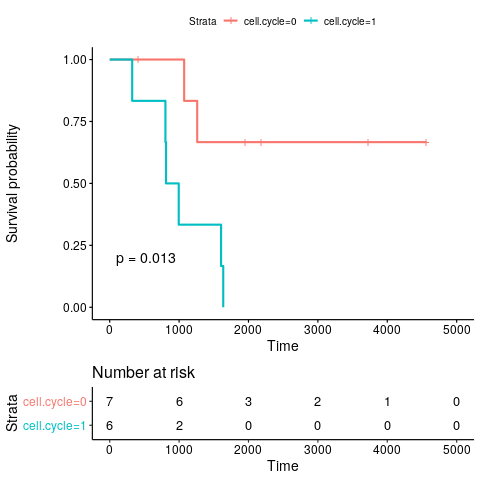

In [16]:
%%R

fit <- survfit(Surv(OS, vital) ~ cell.cycle, data=surv)
g <- ggsurvplot(fit, conf.int=F, pval=T, risk.table=T)
ggsave( "/home/jpfeil/MEGAsync/Dropbox/hydra-paper/MYCNna/cluster-3-sub-cluster-cell-cycle-OS-survival.png", 
       print(g), 
       dpi = 1000 )
g

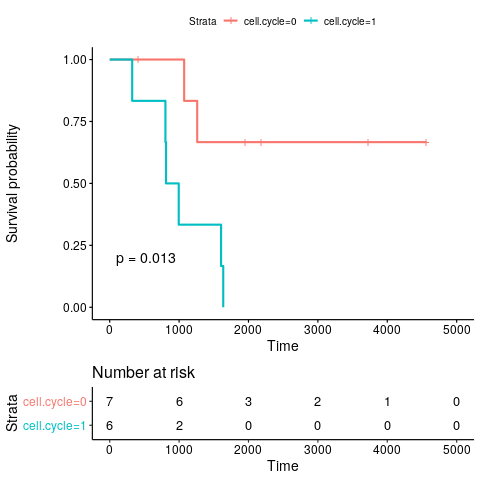

In [17]:
%%R

fit <- survfit(Surv(EFS, event) ~ cell.cycle, data=surv)
ggsurvplot(fit, conf.int=F, pval=T, risk.table=TRUE)
ggsave( "/home/jpfeil/MEGAsync/Dropbox/hydra-paper/MYCNna/cluster-3-sub-cluster-cell-cycle-EFS-survival.png", 
       print(g), 
       dpi = 1000 )
g